## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


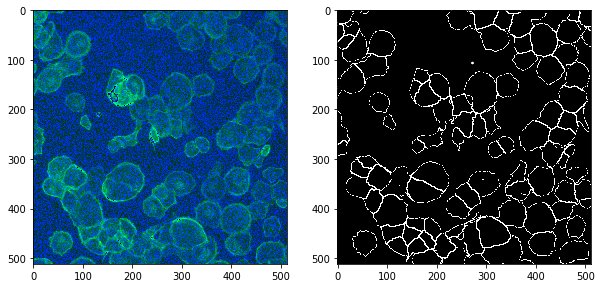

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [5]:
import torch
from torchvision import transforms as T, models as M
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os, glob, time, copy, random
from PIL import Image

In [6]:
class CancerCellDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        super(CancerCellDataset, self).__init__()
        
        # Get sorted image/mask paths.
        images = glob.glob(os.path.join(image_path, '*.bmp'))
        images.sort()
        masks = glob.glob(os.path.join(mask_path, '*.png'))
        masks.sort()
        
        self.data = list(zip(images, masks))
        
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image_path, mask_path = self.data[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # "Synchronize" transformation of images and masks using same random seed.
        seed = np.random.randint(2147483647)
        if self.image_transform is not None:
            random.seed(seed)
            image = self.image_transform(image)
        if self.mask_transform is not None:
            random.seed(seed)
            mask = self.mask_transform(mask)
        
        mask = (mask > 0).float()
        return image, mask

    def __len__(self):
        return len(self.data)

In [7]:
# Prepare the data

image_dir = './BBBC018_v1_images-fixed/'
mask_dir = './BBBC018_v1_outlines/'

stages = ['train', 'val']

image_transforms = {
    'train': T.Compose([T.RandomHorizontalFlip(),
#                         T.RandomVerticalFlip(),
                        T.RandomRotation(180),
                        T.RandomResizedCrop(512, scale=(.7, 1.)),
                        T.ColorJitter(brightness=0.2, contrast=0.2),
                        T.ToTensor()]),
    'val'  : T.ToTensor()}
mask_transforms = {
    'train': T.Compose([T.RandomHorizontalFlip(),
#                         T.RandomVerticalFlip(),
                        T.RandomRotation(180),
                        T.RandomResizedCrop(512, scale=(.7, 1.)),
                        T.ToTensor()]),
    'val'  : T.ToTensor()}


datasets = {stage: CancerCellDataset(os.path.join(image_dir, stage),
                                     os.path.join(mask_dir, stage),
                                     image_transform=image_transforms[stage],
                                     mask_transform=mask_transforms[stage])
            for stage in stages}

batch_sizes = {'train': 3,
               'val': 7}

dataloaders = {stage: torch.utils.data.DataLoader(datasets[stage],
                                                  batch_size=batch_sizes[stage],
                                                  shuffle=True,
                                                  num_workers=32,
                                                  drop_last=False)
               for stage in stages}

dataset_sizes = {stage: len(datasets[stage]) for stage in stages}

In [8]:
# U-net from the paper https://arxiv.org/pdf/1505.04597.pdf
# Implementated using some ideas from 
# https://github.com/milesial/Pytorch-UNet and https://github.com/ternaus/TernausNet

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.double_conv = DoubleConv2d(in_channels, in_channels*2)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels):
        super(Up, self).__init__()
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv_up = nn.Conv2d(in_channels, in_channels//2, kernel_size=2)
        self.relu = nn.ReLU()
        self.double_conv = DoubleConv2d(in_channels, in_channels//2)
    
    def forward(self, x, copy):
        # Up-Convolution
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.pad(x)
        x = self.conv_up(x)
        x = self.relu(x)
        
        # Concatenate
        x = torch.cat([copy, x], dim=1)
        
        # Two Conv layers
        x = self.double_conv(x)
        return x
    
class In(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(In, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, pretrained_encoder=False):
        super(UNet, self).__init__()
        self.inp = DoubleConv2d(3, 64)
        self.down1 = Down(64)
        self.down2 = Down(128)
        self.down3 = Down(256)
        self.down4 = Down(512)
        self.up1 = Up(1024)
        self.up2 = Up(512)
        self.up3 = Up(256)
        self.up4 = Up(128)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
        if pretrained_encoder == True:
            encoder = M.vgg13_bn(pretrained=True).features
            
            self.inp.conv1 = encoder[0]
            self.inp.bn1 = encoder[1]
            self.inp.conv2 = encoder[3]
            self.inp.bn2 = encoder[4]
            
            self.down1.double_conv.conv1 = encoder[7]
            self.down1.double_conv.bn1 = encoder[8]
            self.down1.double_conv.conv2 = encoder[10]
            self.down1.double_conv.bn2 = encoder[11]
            
            self.down2.double_conv.conv1 = encoder[14]
            self.down2.double_conv.bn1 = encoder[15]
            self.down2.double_conv.conv2 = encoder[17]
            self.down2.double_conv.bn2 = encoder[18]
            
            self.down3.double_conv.conv1 = encoder[21]
            self.down3.double_conv.bn1 = encoder[22]
            self.down3.double_conv.conv2 = encoder[24]
            self.down3.double_conv.bn2 = encoder[25]
            
    def forward(self, x):
        x1 = self.inp(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return x

In [9]:
# Training loop
loss_history = {'train': [], 'val': []}
best_acc = 0.0

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, return_last=False, PSP=False):
    since = time.time()

    global best_model_wts
    best_model_wts = copy.deepcopy(model.state_dict())
    
    global best_acc
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_epoch = time.time()
        
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0.0

            # Iterate over data.
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if PSP == True:
                        outputs = outputs[0]
                    
                    loss = criterion(outputs.view(-1), masks.view(-1))
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                predicted_mask = (outputs.detach() >= 0)
                running_iou += calc_iou(predicted_mask.cpu().numpy(), masks.cpu().numpy()) * (batch_size / dataset_sizes[phase])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_iou = running_iou

            time_stage = time.time() - since_epoch
            print('{} Loss: {:.4f} IoU: {:.4f} Time: {:.1f} sec'.format(
                phase, epoch_loss, epoch_iou, time_stage))
            
            loss_history[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_iou > best_acc:
                best_acc = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val IoU: {:4f}'.format(best_acc))

    # load best model weights
    if return_last == False:
        model.load_state_dict(best_model_wts)
    return model

In [10]:
# Visualization: (predicted mask probabilities, predicted mask, ground truth)
# i - index of validation sample to use
def maskshow(i=0, PSP=False):
    inp, mask = datasets['val'][i]
    out = net(inp.to(device)[None,...])
    if PSP == True:
        out = out[0]

    mask_pred = out[0,0].detach().sigmoid().cpu().numpy()
    mask = mask[0].cpu().numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(mask_pred, 'gray', vmax=1, vmin=0)
    plt.subplot(1,3,2)
    plt.imshow(mask_pred.round(), 'gray', vmax=1, vmin=0)
    plt.subplot(1,3,3)
    plt.imshow(mask, 'gray', vmax=1, vmin=0)

In [11]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [12]:
net = UNet(pretrained_encoder=True)
net = net.to(device)

# pos to neg in the train dataset is .961 : .039
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(.961 / .039, dtype=torch.float32, device=device))

optimizer = optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

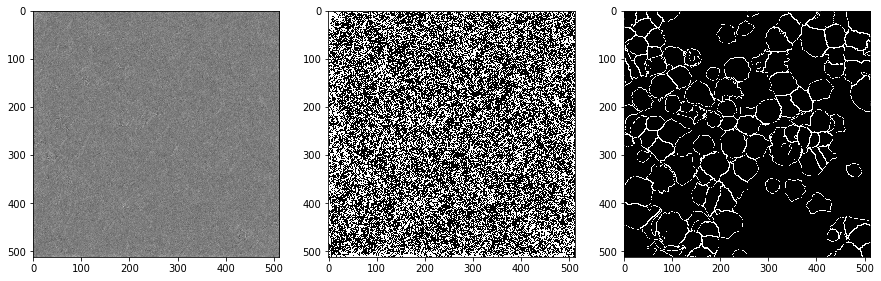

In [13]:
# Network output before training
maskshow()

In [14]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs=50, return_last=False)

Epoch 0/49
----------
train Loss: 0.6717 IoU: 0.1568 Time: 19.1 sec
val Loss: 0.7003 IoU: 0.1591 Time: 1.8 sec

Epoch 1/49
----------
train Loss: 0.4681 IoU: 0.1997 Time: 19.1 sec
val Loss: 0.5405 IoU: 0.1955 Time: 1.9 sec

Epoch 2/49
----------
train Loss: 0.4152 IoU: 0.2257 Time: 19.3 sec
val Loss: 0.6211 IoU: 0.2256 Time: 1.8 sec

Epoch 3/49
----------
train Loss: 0.3822 IoU: 0.2421 Time: 19.2 sec
val Loss: 1.0435 IoU: 0.0670 Time: 1.9 sec

Epoch 4/49
----------
train Loss: 0.3716 IoU: 0.2487 Time: 19.2 sec
val Loss: 0.5437 IoU: 0.1992 Time: 1.8 sec

Epoch 5/49
----------
train Loss: 0.3415 IoU: 0.2593 Time: 19.3 sec
val Loss: 0.7045 IoU: 0.2278 Time: 1.8 sec

Epoch 6/49
----------
train Loss: 0.3277 IoU: 0.2763 Time: 19.2 sec
val Loss: 0.5261 IoU: 0.2043 Time: 1.9 sec

Epoch 7/49
----------
train Loss: 0.3092 IoU: 0.2771 Time: 19.2 sec
val Loss: 0.5597 IoU: 0.2292 Time: 1.8 sec

Epoch 8/49
----------
train Loss: 0.3097 IoU: 0.2866 Time: 19.2 sec
val Loss: 0.6379 IoU: 0.2335 Time: 1

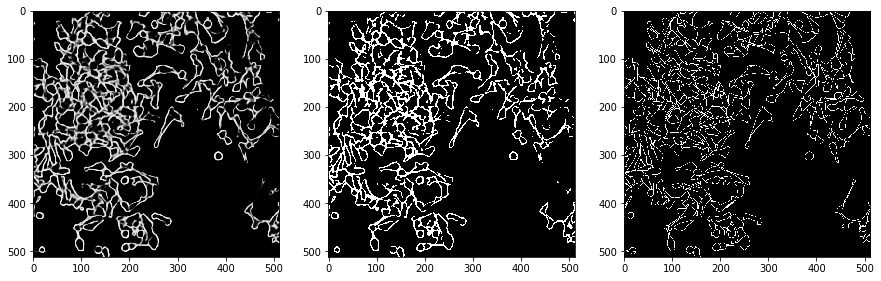

In [15]:
# Network output after training
maskshow(3)

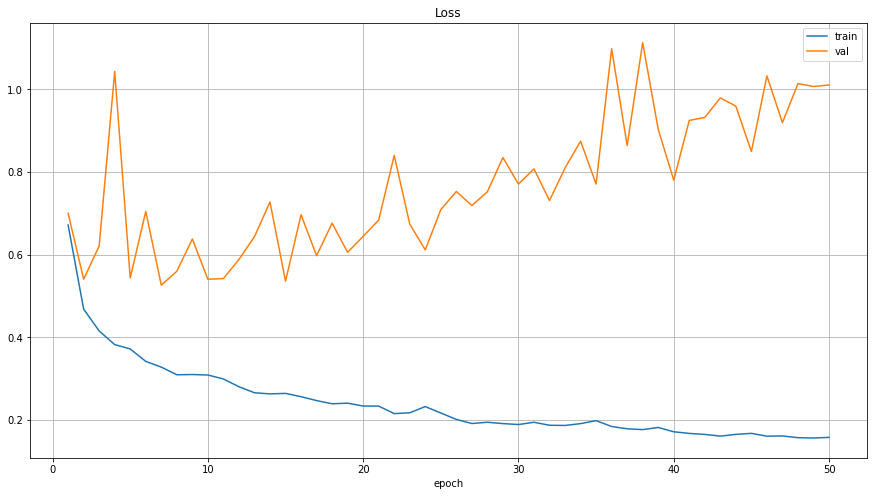

In [17]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,1+len(loss_history['train'])), loss_history['train'], label='train')
plt.plot(np.arange(1,1+len(loss_history['val'])), loss_history['val'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
# plt.ylim(.1, .5)
plt.show()

In [45]:
### Save the network
# torch.save(net, 'unet3.pth.tar')
# torch.save(net.state_dict(), 'unet3_dict.pth.tar')
# loss = np.concatenate((np.array(loss_history['train'])[:, None], np.array(loss_history['val'])[:, None]), axis=1)
# np.savetxt('unet3_loss.txt', loss)

In [41]:
# net = UNet(pretrained_encoder=True)
# net = net.to(device)

# # load the model
# net.load_state_dict(torch.load('unet_dict.pth.tar'))
# net = net.to(device)

# # # load the loss history
# loss_history_np = np.loadtxt('unet_loss.txt')
# loss_history = {'train': list(loss_history_np[:,0]), 'val': list(loss_history_np[:,1])}

In [12]:
# PSPnet. Code from https://github.com/Lextal/pspnet-pytorch

from collections import OrderedDict
import math
from torch.utils import model_zoo
from torchvision.models.densenet import densenet121, densenet161
from torchvision.models.squeezenet import squeezenet1_1


def load_weights_sequential(target, source_state):
    model_to_load= {k: v for k, v in source_state.items() if k in target.state_dict().keys()}
    target.load_state_dict(model_to_load)
#     new_dict = OrderedDict()
#     for (k1, v1), (k2, v2) in zip(target.state_dict().items(), source_state.items()):
#         new_dict[k1] = v2
#     target.load_state_dict(new_dict)

'''
    Implementation of dilated ResNet-101 with deep supervision. Downsampling is changed to 8x
'''
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, dilation=dilation, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride=1, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, dilation=dilation,
                               padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers=(3, 4, 23, 3)):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x_3 = self.layer3(x)
        x = self.layer4(x_3)

        return x, x_3


'''
    Implementation of DenseNet with deep supervision. Downsampling is changed to 8x 
'''


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm.1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu.1', nn.ReLU(inplace=True)),
        self.add_module('conv.1', nn.Conv2d(num_input_features, bn_size *
                                            growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm.2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu.2', nn.ReLU(inplace=True)),
        self.add_module('conv.2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                            kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, downsample=True):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        if downsample:
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
        else:
            self.add_module('pool', nn.AvgPool2d(kernel_size=1, stride=1))  # compatibility hack


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, pretrained=True):

        super(DenseNet, self).__init__()

        # First convolution
        self.start_features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features

        init_weights = list(densenet121(pretrained=True).features.children())
        start = 0
        for i, c in enumerate(self.start_features.children()):
            if pretrained:
                c.load_state_dict(init_weights[i].state_dict())
            start += 1
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            if pretrained:
                block.load_state_dict(init_weights[start].state_dict())
            start += 1
            self.blocks.append(block)
            setattr(self, 'denseblock%d' % (i + 1), block)

            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                downsample = i < 1
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                    downsample=downsample)
                if pretrained:
                    trans.load_state_dict(init_weights[start].state_dict())
                start += 1
                self.blocks.append(trans)
                setattr(self, 'transition%d' % (i + 1), trans)
                num_features = num_features // 2

    def forward(self, x):
        out = self.start_features(x)
        deep_features = None
        for i, block in enumerate(self.blocks):
            out = block(out)
            if i == 5:
                deep_features = out

        return out, deep_features


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes, dilation=1):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=dilation, dilation=dilation)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, pretrained=False):
        super(SqueezeNet, self).__init__()

        self.feat_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.feat_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64)
        )
        self.feat_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(128, 32, 128, 128, 2),
            Fire(256, 32, 128, 128, 2)
        )
        self.feat_4 = nn.Sequential(
            Fire(256, 48, 192, 192, 4),
            Fire(384, 48, 192, 192, 4),
            Fire(384, 64, 256, 256, 4),
            Fire(512, 64, 256, 256, 4)
        )
        if pretrained:
            weights = squeezenet1_1(pretrained=True).features.state_dict()
            load_weights_sequential(self, weights)

    def forward(self, x):
        f1 = self.feat_1(x)
        f2 = self.feat_2(f1)
        f3 = self.feat_3(f2)
        f4 = self.feat_4(f3)
        return f4, f3


'''
    Handy methods for construction
'''


def squeezenet(pretrained=True):
    return SqueezeNet(pretrained)


def densenet(pretrained=True):
    return DenseNet(pretrained=pretrained)


def resnet18(pretrained=True):
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=True):
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 23, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=True):
    model = ResNet(Bottleneck, [3, 8, 36, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet152']))
    return model

#=====================================================================================================

class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class PSPUpsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        h, w = 2 * x.size(2), 2 * x.size(3)
        p = F.upsample(input=x, size=(h, w), mode='bilinear')
        return self.conv(p)


class PSPNet(nn.Module):
    def __init__(self, n_classes=1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet34',
                 pretrained=True):
        super().__init__()
#         self.feats = getattr(extractors, backend)(pretrained)
        self.feats = globals()[backend](pretrained)
        self.psp = PSPModule(psp_size, 1024, sizes)
        self.drop_1 = nn.Dropout2d(p=0.3)

        self.up_1 = PSPUpsample(1024, 256)
        self.up_2 = PSPUpsample(256, 64)
        self.up_3 = PSPUpsample(64, 64)

        self.drop_2 = nn.Dropout2d(p=0.15)
        self.final = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
#             nn.LogSoftmax()
        )

        self.classifier = nn.Sequential(
            nn.Linear(deep_features_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        f, class_f = self.feats(x) 
        p = self.psp(f)
        p = self.drop_1(p)

        p = self.up_1(p)
        p = self.drop_2(p)

        p = self.up_2(p)
        p = self.drop_2(p)

        p = self.up_3(p)
        p = self.drop_2(p)

        auxiliary = F.adaptive_max_pool2d(input=class_f, output_size=(1, 1)).view(-1, class_f.size(1))

        return self.final(p), self.classifier(auxiliary)
    
#=========================================================================================================

models = {
    'squeezenet': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='squeezenet'),
    'densenet': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet'),
    'resnet18': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet18'),
    'resnet34': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet34'),
    'resnet50': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet50'),
    'resnet101': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet101'),
    'resnet152': lambda: PSPNet(sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet152')
}


def build_network(snapshot, backend):
    epoch = 0
    backend = backend.lower()
    net = models[backend]()
    net = nn.DataParallel(net)
    if snapshot is not None:
        _, epoch = os.path.basename(snapshot).split('_')
        epoch = int(epoch)
        net.load_state_dict(torch.load(snapshot))
        logging.info("Snapshot for epoch {} loaded from {}".format(epoch, snapshot))
    net = net.to(device)
    return net, epoch

In [30]:
net, _ = build_network(None, 'resnet18')

In [31]:
# .961 / .039
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(.961 / .039, dtype=torch.float32, device=device))

optimizer = optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

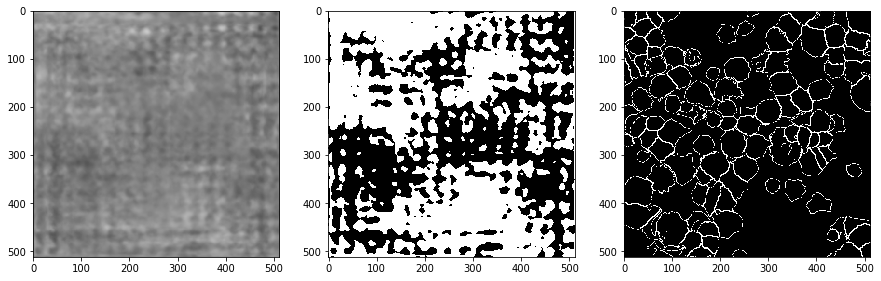

In [32]:
# Network output before training
maskshow(0, PSP=True)

In [ ]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs=5, return_last=False, PSP=True)

In [ ]:
# Network output after training
maskshow(0, PSP=True)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,1+len(loss_history['train'])), loss_history['train'], label='train')
plt.plot(np.arange(1,1+len(loss_history['val'])), loss_history['val'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
# plt.ylim(.1, .5)
plt.show()